In [1]:
%matplotlib inline
# %matplotlib qt
import json
import numpy as np
import matplotlib.pyplot as plt

import qcodes as qc
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.experiment_container import load_by_id
from qcodes.dataset.plotting import plot_by_id

import nanotune as nt
from nanotune.model.capacitancemodel import CapacitanceModel

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /Users/jana/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : /Users/jana/.qcodes/logs/210415-36003-qcodes.log


## Capacitance model


Illustration of capacitances between gates as well as gates and dots:
<img src="quantum_dots-08.png" width="300"/>
Names and layout indices of gates:
<img src="quantum_dots-09.png" width="200"/>


Initiate or set database where data should be saved. When initializing a database a new qcodes experiment needs to be created as well.

In [2]:
exp_name = 'capacitance_extraction'
sample_name = 'capa_model'
db_name = 'capa_model_test.db'
nt.new_database(db_name, '.')
new_experiment(exp_name, sample_name)
# nt.set_database(db_name)

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 59.82it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 68.00it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v8 -> v9: 100%|██████████| 1/1 [00:00<00:00, 50.45it/s]


capacitance_extraction#capa_model#1@/Users/jana/Documents/code/nanotune/nanotune/docs/capacitance_model/capa_model_test.db
--------------------------------------------------------------------------------------------------------------------------

Initialize an instance of CapacitanceModel with six gates and two dots

In [3]:
voltage_nodes = {
    0: 'top_barrier',
    1: 'left_barrier',
    2: 'left_plunger',
    3: 'central_barrier',
    4: 'right_plunger',
    5: 'right_barrier',
}
charge_nodes = {
    0: 'A',
    1: 'B'
}
dot_handles = {
    'A': 2,
    'B': 4,
}

qdot = CapacitanceModel(
    'qdot',
    charge_nodes=charge_nodes,
    voltage_nodes=voltage_nodes,
    dot_handles=dot_handles,
    db_name=db_name,
    db_folder='.'
)


Set voltages, define capacitance matrix and calculate ground state dot occupation

In [4]:
qdot.V_v([
    -1,  # top_barrier
    -0.1,  # left_barrier
    -4.2,  # left_plunger
    -1,  # central_barrier
    -0.5,  # right_plunger
    -0.3,  # right_barrier
])
# inter-dot capacitance
qdot.C_cc([[-8e-18]])
# capacitances between gates and dots
#           top_b    left_b left_p center right_p  right_b    
qdot.C_cv([[0.5e-18, 1e-18, 5e-18, 1e-18, 0.1e-18, 0.1e-18],   #  A
           [0.5e-18, 0.1e-18, 1e-18, 2e-18, 9e-18, 2e-18]])    #  B

print(qdot.determine_N())

[14.0, 7.0]


Define which dot occupancies to probe and calculate respective voltage ranges of two gates to sweep.

In [5]:
N_limits = [(0, 3), (0, 3)]
sweep_ranges = qdot.determine_sweep_voltages([2, 4], N_limits=N_limits)
print(sweep_ranges)

[[0.31981233977907475, -0.6329423026592067], [0.31003555776603053, -0.1181622049334346]]


Starting experimental run with id: 3. 
CPU times: user 2min 18s, sys: 12.4 s, total: 2min 30s
Wall time: 1min 28s


([<AxesSubplot:title={'center':'Run #3, Experiment capacitance_extraction (capa_model)'}, xlabel='voltage node left_plunger (V[2]) (mV)', ylabel='voltage node right_plunger (V[4]) (mV)'>],
 [<matplotlib.colorbar.Colorbar at 0x7f8f61f62d90>])

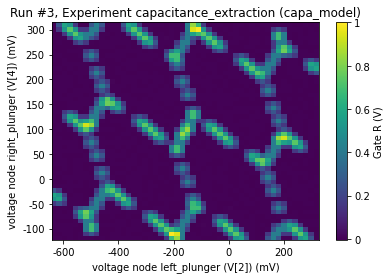

In [8]:
%%time
dataid = qdot.sweep_voltages(
    [2, 4],
     sweep_ranges,
     n_steps=[50,50],
     target_snr_db=10,
     e_temp=2e-21,
     kernel_widths=[1, 1],  # for broadening with gaussian_filter
     broaden=True,
     add_noise=True,
     add_charge_jumps=False,
)
plot_by_id(dataid)

Sweep one voltage to show Coulomb oscillations

Starting experimental run with id: 1. 
CPU times: user 5.93 s, sys: 551 ms, total: 6.48 s
Wall time: 4.49 s


([<AxesSubplot:title={'center':'Run #1, Experiment capacitance_extraction (capa_model)'}, xlabel='voltage node left_plunger (V[2]) (mV)', ylabel='Gate R (V)'>],
 [None])

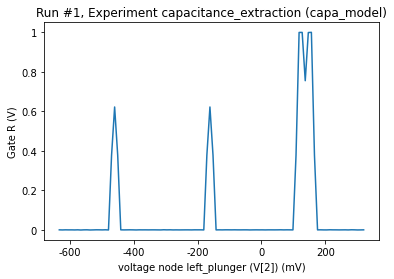

In [6]:
%%time
dataid = qdot.sweep_voltage(2, sweep_ranges[0],
                            n_steps=100,
                            target_snr_db=20,
                            e_temp=3e-21,
                           )
plot_by_id(dataid)